# Setp

In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive', force_remount=True)

os.chdir('drive/MyDrive/CV')

Mounted at /content/drive


In [ ]:
# !pip install albumentations==0.4.6
# !pip install opencv-python-headless==4.1.2.30

In [ ]:
import numpy as np
import random
import math
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import sampler
import torchvision.datasets as dset
import torchvision.transforms as T
from torchvision.utils import save_image
import albumentations as A
from albumentations.pytorch import ToTensorV2

from PIL import Image

torch.set_printoptions(threshold=5000)

## Data Preparation:



In [ ]:
class FaceDataset(Dataset):
    def __init__(self, root_anime, root_real):
        self.root_anime = root_anime
        self.root_real = root_real

        self.anime_imgs = os.listdir(root_anime)
        self.real_imgs = os.listdir(root_real)
        self.anime_len = len(self.anime_imgs)
        self.real_len = len(self.real_imgs)

        self.data_n = max(self.anime_len, self.real_len) # 
        self.transform = A.Compose(
            [A.Resize(width=256, height=256),
             A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255),
             ToTensorV2(),
            ],
            additional_targets={"image0": "image"})

    def __getitem__(self, index):
        anime_img = self.anime_imgs[index % self.anime_len]
        real_img = self.real_imgs[index % self.real_len]

        anime_path = os.path.join(self.root_anime, anime_img)
        real_path = os.path.join(self.root_real, real_img)

        anime_img = np.array(Image.open(anime_path).convert("RGB"))
        real_img = np.array(Image.open(real_path).convert("RGB"))
        
        transformed = self.transform(image=anime_img, image0=real_img)
        anime_img = transformed["image"]
        real_img = transformed["image0"]

        return real_img, anime_img

    
    def __len__(self):
        return self.data_n

In [ ]:
# hyperparamters for data loading
TRAIN_DIR = 'data/train'
VAL_DIR = 'data/validation'
BATCH_SIZE = 1

In [ ]:
# initialize dataset and dataloaders
train_dataset = FaceDataset(root_anime=os.path.join(TRAIN_DIR, 'anime'), 
            root_real=os.path.join(TRAIN_DIR, 'real'))
val_dataset = FaceDataset(root_anime=os.path.join(VAL_DIR, 'anime'), 
            root_real=os.path.join(VAL_DIR, 'real'))
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, 
            shuffle=True, num_workers=16, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, 
            shuffle=False,pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Now we will see how a sample looks like.

In [ ]:
# from google.colab.patches import cv2_imshow
# import cv2

# def show(img):
#     img = cv2.resize(img, (256,256), interpolation = cv2.INTER_AREA)
#     cv2_imshow(img)


# Discriminator

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super().__init__()
        self.n_features = [64, 128, 256, 512]
        self.initial = nn.Sequential(
            nn.Conv2d(in_channels, self.n_features[0], kernel_size=4,
                 stride=2, padding=1, padding_mode="reflect"),
            nn.LeakyReLU(0.2, inplace=True),
        )
        # prepare other conv blocsk
        layers = []
        in_channels = self.n_features[0]
        for feature in self.n_features[1:]:
            if feature == self.n_features[-1]:
                stride = 1
            else:
                stride = 2
            layers.append(ConvBlock(in_channels, feature, stride=stride))
            in_channels = feature
        # output layers
        layers.append(nn.Conv2d(in_channels, 1, kernel_size=4, stride=1, padding=1, padding_mode="reflect"))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        output = self.initial(x)
        output = self.model(output)
        probs = torch.sigmoid(output)

        return probs

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride, padding=1):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 4, stride, padding, bias=True, padding_mode="reflect"),
            nn.LeakyReLU(0.2, inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

# Generator

In [ ]:
class Generator(nn.Module):
    def __init__(self, img_channels=3, n_features=64, n_res=9):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(img_channels, n_features, kernel_size=7, stride=1, padding=3, padding_mode="reflect"),
            nn.ReLU(inplace=True),
        )
        self.down_blocks = nn.ModuleList(
            [Conv2Block(n_features, n_features*2, kernel_size=3, stride=2, padding=1),
            Conv2Block(n_features*2, n_features*4, kernel_size=3, stride=2, padding=1)])
        self.residual_blocks = nn.Sequential(
            *[ResidualBlock(n_features*4) for _ in range(n_res)])
        self.up_blocks = nn.ModuleList(
            [Conv2Block(n_features*4, n_features*2, up=True, kernel_size=3, stride=2, padding=1, output_padding=1),
            Conv2Block(n_features*2, n_features, up=True, kernel_size=3, stride=2, padding=1, output_padding=1),
            ])
        # convert back to RGB
        self.out = nn.Conv2d(n_features, img_channels, kernel_size=7, stride=1, padding=3, padding_mode="reflect")
        
    def forward(self, x):
        output = self.initial(x)
        for layer in self.down_blocks:
            output = layer(output)
        output = self.residual_blocks(output)
        for layer in self.up_blocks:
            output = layer(output)
        output = self.out(output)
        output = torch.tanh(output)
        
        return output


class ResidualBlock(nn.Module):
    def __init__(self, channels, n_blocks=2):
        super().__init__()
        self.block = nn.Sequential(
            *[Conv2Block(channels, channels, kernel_size=3, padding=1) for _ in range(n_blocks)]
        )

    def forward(self, x):
        return x + self.block(x)


class Conv2Block(nn.Module):
    def __init__(self, in_channels, out_channels, up=False, **kwargs):
        super().__init__()
        self.conv2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, **kwargs)
            if up
            else nn.Conv2d(in_channels, out_channels, padding_mode="reflect", **kwargs),
            nn.InstanceNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv2(x)

# Setup for Training 

In [ ]:
# environment parameters
SEED = 42
def seed_everything(seed):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
seed_everything(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CKPT_GEN_real = "gen_r.pth.tar"
CKPT_GEN_anime = "gen_a.pth.tar"
CKPT_DISC_real = "disc_r.pth.tar"
CKPT_DISC_anime = "disc_a.pth.tar"

In [ ]:
# set up hyperparamters for training
EPOCHS = 5
LEARNING_RATE = 1e-4
BETAS = (0.55, 0.999)
LAMBDA = 10

In [ ]:
def trainer(disc_real, disc_anime, gen_real, gen_anime, dataloader, 
    optim_disc, optim_gen, cycle_loss, adv_loss, disc_scaler, gen_scaler
):
    anime_trues = 0
    anime_fakes = 0
    real_trues = 0
    real_fakes = 0
    loop = tqdm(dataloader, leave=True)

    for idx, batch in enumerate(loop):
        real, anime = batch
        real = real.to(device)
        anime = anime.to(device)

        # Train discriminators 
        with torch.cuda.amp.autocast():
            # anime discriminator
            fake_anime = gen_anime(real)
            Disc_anime_true = disc_anime(anime)
            Disc_anime_fake = disc_anime(fake_anime.detach())
            anime_trues += Disc_anime_true.mean().item()
            anime_fakes += Disc_anime_fake.mean().item()
            Disc_anime_trues_loss = adv_loss(Disc_anime_true, torch.ones_like(Disc_anime_true))
            Disc_anime_fakes_loss = adv_loss(Disc_anime_fake, torch.zeros_like(Disc_anime_fake))
            Disc_anime_loss = Disc_anime_trues_loss + Disc_anime_fakes_loss
            # real face discriminator
            fake_real = gen_real(anime)
            Disc_real_true = disc_real(real)
            Disc_real_fake = disc_real(fake_real.detach())
            real_trues += Disc_real_true.mean().item()
            real_fakes += Disc_real_fake.mean().item()
            Disc_real_trues_loss = adv_loss(Disc_real_true, torch.ones_like(Disc_real_true))
            Disc_real_fakes_loss = adv_loss(Disc_real_fake, torch.zeros_like(Disc_real_fake))
            Disc_real_loss = Disc_real_trues_loss + Disc_real_fakes_loss

            # total loss
            Disc_loss = (Disc_anime_loss + Disc_real_loss) / 2

        optim_disc.zero_grad()
        disc_scaler.scale(Disc_loss).backward()
        disc_scaler.step(optim_disc)
        disc_scaler.update()

        # Train Generators 
        with torch.cuda.amp.autocast():
            # generator loss
            Disc_anime_fake = disc_anime(fake_anime)
            Disc_real_fake = disc_real(fake_real)
            Gen_anime_loss = adv_loss(Disc_anime_fake, torch.ones_like(Disc_anime_fake))
            Gen_real_loss = adv_loss(Disc_real_fake, torch.ones_like(Disc_real_fake))

            # cycle loss
            cycle_anime = gen_anime(fake_real)
            cycle_real = gen_real(fake_anime)
            cycle_anime_loss = cycle_loss(cycle_anime, anime)
            cycle_real_loss = cycle_loss(cycle_real, real)

            # identity loss
            identity_anime = gen_anime(anime)
            identity_real = gen_real(real)
            identity_anime_loss = cycle_loss(anime, identity_anime)
            identity_real_loss = cycle_loss(real, identity_real)

            # total loss
            Gen_loss = (Gen_anime_loss 
                + Gen_real_loss
                + cycle_anime_loss * LAMBDA
                + cycle_real_loss * LAMBDA
                + identity_anime_loss
                + identity_real_loss)

        optim_gen.zero_grad()
        gen_scaler.scale(Gen_loss).backward()
        gen_scaler.step(optim_gen)
        gen_scaler.update()

        if idx % 200 == 0:
            save_image(fake_anime*0.5 + 0.5, f"sample/fake_anime_{idx}.png")
            save_image(fake_real*0.5 + 0.5, f"sample/fake_real_{idx}.png")
            save_image(cycle_anime*0.5 + 0.5, f"sample/cycle_anime_{idx}.png")
            save_image(cycle_real*0.5 + 0.5, f"sample/cycle_real_{idx}.png")

        loop.set_postfix(anime_trues=anime_trues/(idx+1), anime_fakes=anime_fakes/(idx+1),
                real_trues=real_trues/(idx+1), real_fakes=real_fakes/(idx+1))

In [ ]:
# model saving and loading functions
def save_checkpoint(model, optimizer, filename="ckpt.pth.tar"):
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(checkpoint, filename)


def load_checkpoint(checkpoint_file, model, optimizer, lr):
    checkpoint = torch.load(checkpoint_file, map_location=device)
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

# Training

In [ ]:
# initialize models
disc_real = Discriminator().to(device)
disc_anime = Discriminator().to(device)
gen_real = Generator(n_res=9).to(device)
gen_anime = Generator(n_res=9).to(device)

# initialize parameters and optimzers
disc_param_lst = list(disc_real.parameters()) + list(disc_anime.parameters())
gen_param_lst = list(gen_real.parameters()) + list(gen_anime.parameters())

optim_disc = optim.Adam(disc_param_lst, lr=LEARNING_RATE, betas=BETAS)
optim_gen = optim.Adam(gen_param_lst, lr=LEARNING_RATE, betas=BETAS)

# initialize loss 

cycle_loss = nn.L1Loss()
adv_loss = nn.MSELoss()

# initialize gradient scaler for numerical stability

gen_scaler = torch.cuda.amp.GradScaler()
disc_scaler = torch.cuda.amp.GradScaler()


In [ ]:
for epoch in range(EPOCHS):
    trainer(disc_real, disc_anime, gen_real, gen_anime, train_loader, 
        optim_disc, optim_gen, cycle_loss, adv_loss, gen_scaler, disc_scaler)

    save_checkpoint(gen_real, optim_gen, filename=CKPT_GEN_real)
    save_checkpoint(gen_anime, optim_gen, filename=CKPT_GEN_anime)
    save_checkpoint(disc_real, optim_disc, filename=CKPT_DISC_real)
    save_checkpoint(disc_anime, optim_disc, filename=CKPT_DISC_anime)

  0%|          | 0/3400 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 3400/3400 [40:01<00:00,  1.42it/s, anime_fakes=0.343, anime_trues=0.654, real_fakes=0.381, real_trues=0.62]


# Create Output Grid

In [ ]:
load_checkpoint(CKPT_GEN_anime, gen_anime, optim_gen, LEARNING_RATE)

In [ ]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as vision_F

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False, figsize=(16, 12))
    for i, img in enumerate(imgs):
        img = img.detach()
        img = vision_F.to_pil_image(img)    
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
        


In [ ]:
#torch.cuda.empty_cache()

In [ ]:
from torchvision.utils import make_grid
img_list = []

In [ ]:
loop = tqdm(val_loader, leave=True)
for idx, batch in enumerate(loop):
    if idx >= 60:
        break
    real, _ = batch
    fake_anime = gen_anime(real.to(device))
    fake_torch = fake_anime.squeeze(0).detach().cpu()
    fake_torch = (fake_torch*0.5+0.5)
    real = (real*0.5+0.5).squeeze(0)
    img_list.extend([real, fake_torch])


 60%|██████    | 60/100 [00:02<00:01, 25.98it/s]


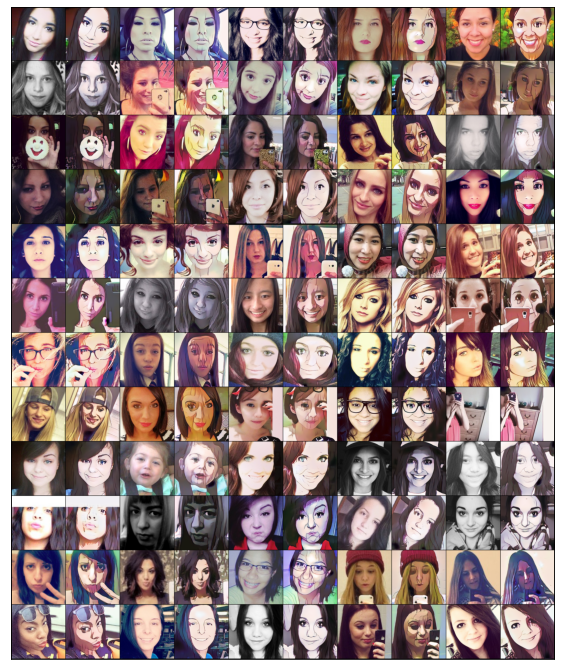

In [ ]:
grid = make_grid(img_list, nrow=10)
show(grid)

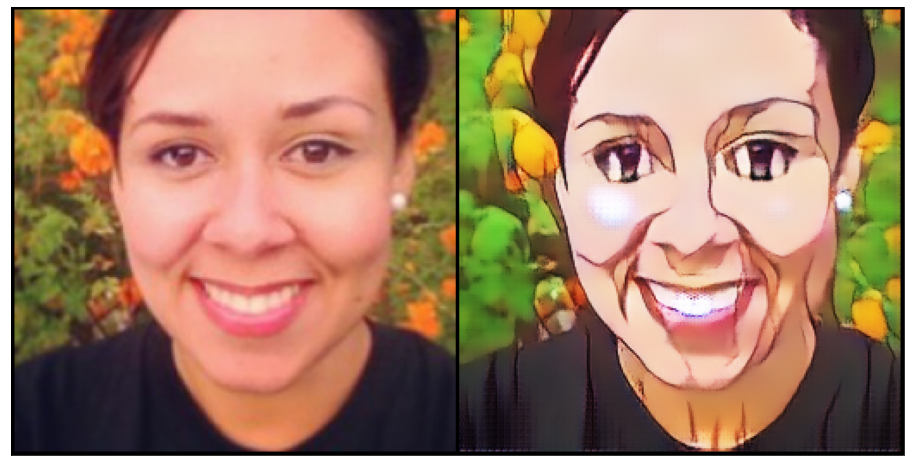

In [ ]:
best = img_list[8:10]
grid_best = make_grid(best, nrow=2)
show(grid_best)

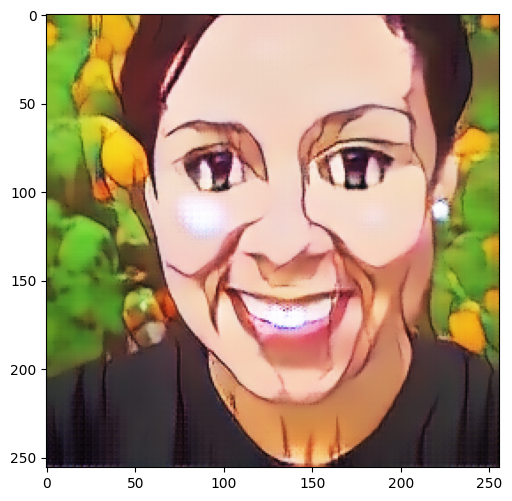

In [ ]:
plt.figure(figsize=(12, 6), dpi=100)
img = vision_F.to_pil_image(best)    
plt.imshow(np.asarray(img))